# COVID-19 Therapeutics Project
### by Thomas L. Ragsdale, MPH

This project aims to describe the availability of drugs used to treat COVID-19 throughout the Commonwealth of Virginia. Future analytic stages will compare this therapeutic availability with population densities and case incidence rates across geographic localities in Virginia.

***

### Table of Contents
 *  __[Data Preparation](#Data-Preparation)__
 *  __[Descriptive Analysis](#Descriptive-Analysis)__
 *  __[Geographic Analysis](#Geographic-Analysis)__

## Data Preparation
<a id=#Data-Preparation></a>

The United States Department of Health and Human Services (HHS) has compiled a locator tool for the public which lists providers of COVID-19 therapeutic drugs and reports the availability of different kinds of these drugs. This data table is available to the public via the __[HealthData.gov API](https://healthdata.gov/Health/COVID-19-Public-Therapeutic-Locator/rxn6-qnx8)__. For this analysis, we will use the `requests` library to import a subset of the data containing only information for Virginia.

For more information on the dataset, click the following link: __[https://healthdata.gov/Health/COVID-19-Public-Therapeutic-Locator/rxn6-qnx8](https://healthdata.gov/Health/COVID-19-Public-Therapeutic-Locator/rxn6-qnx8)__

In [30]:
# Import necessary libraries: 

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import requests

In [31]:
url = "https://healthdata.gov/resource/rxn6-qnx8.json?state_code=VA&$limit=4000"

In [32]:
current_date = pd.Timestamp.today().strftime("%m/%d/%Y") # Today's date will be used to demonstrate transparency.
results = requests.get(url)

In [33]:
therapeutics = pd.json_normalize(results.json())
therapeutics.describe()

# This dataset contains 16 variables and nearly 3000 observations.

,provider_name,address1,city,county,state_code,zip,national_drug_code,order_label,courses_available,npi,last_report_date,provider_status,geocoded_address.type,geocoded_address.coordinates,address2,provider_note
count,2986,2986,2986,2986,2986,2986,2985,2986,2980,2909,2983,2986,2986,2986,1264,77
unique,1121,1174,224,120,1,327,3,4,152,1137,55,2,1,1169,73,1
top,SAFEWAY PHARMACY,6500 GEORGE WASHINGTON MEM HWY,Richmond,Fairfax,VA,23320,00069-1085-30,Paxlovid,5,1447500400,2023-02-16T00:00:00.000,ACTIVE,Point,"[-81.114815, 36.97016]",CVS Pharmacy,Inventory has not been reported in the last 2 ...
freq,72,6,185,323,2986,35,1138,1138,153,6,2415,2909,2986,6,1025,77


At the time of writing, this dataset contains 77 entries with the __provider_status__ variable listed as "UNKNOWN INVENTORY". We are only concerned with "ACTIVE" providers, so any other values for this variable will need to be filtered out. Additionally, we will convert the __courses_available__ (available doses) and __zip__ (postal code) columns to integer format.

In [34]:
# Subset the dataset into a new DataFrame - df - with only active providers.

df = therapeutics[therapeutics.provider_status == "ACTIVE"]
df.provider_status.unique() # Verify that ACTIVE is now the only entry for provider_status.

array(['ACTIVE'], dtype=object)

In [35]:
# Assign the number of therapeutic courses and ZIP code columns to be integers.
# Any missing values will be filled to zero.

df = df.assign(
    courses = df.courses_available.fillna(0).astype("int"),
    zip_code = df.zip.fillna(0).astype("int")
              )
df.head()

,provider_name,address1,city,county,state_code,zip,national_drug_code,order_label,courses_available,npi,last_report_date,provider_status,geocoded_address.type,geocoded_address.coordinates,address2,provider_note,courses,zip_code
0,FAMILY DRUG CENTER,517 West Front Street,Coeburn,Wise,VA,24230,00069-1085-30,Paxlovid,9,1326056482,2023-02-16T00:00:00.000,ACTIVE,Point,"[-82.487, 36.9402]",NaN,NaN,9,24230
1,CVS STORE #03018,7500 CENTREVILLE ROAD,Manassas Park,Manassas Park City,VA,20111,00069-1101-20,Renal Paxlovid,3,1053415729,2023-02-16T00:00:00.000,ACTIVE,Point,"[-77.44822, 38.79268]",CVS Pharmacy,NaN,3,20111
2,WALGREENS STORE #11381,573 N MAIN ST,Kilmarnock,Lancaster,VA,22482,00069-1085-30,Paxlovid,3,1184809584,2023-02-16T00:00:00.000,ACTIVE,Point,"[-76.38936, 37.72435]",NaN,NaN,3,22482
3,CVS STORE #10990,12410 W BROAD ST.,Richmond,Henrico,VA,23233,00006-5055-06,Lagevrio (molnupiravir),13,1063949444,2023-02-16T00:00:00.000,ACTIVE,Point,"[-77.64563, 37.662615]",CVS Pharmacy,NaN,13,23233
4,COSTCO PHARMACY # 340,3102 PLANK RD # 600,Fredericksburg,Spotsylvania,VA,22407,00069-1085-30,Paxlovid,27,1154431781,2023-02-16T00:00:00.000,ACTIVE,Point,"[-77.51304, 38.29573]",NaN,NaN,27,22407


<a id="Descriptive-Analysis"></a>

## Descriptive Analysis

Now we will calculate the number of courses available for the four labels of medicine in this dataset: _Paxlovid &#8482;_, _renal Paxlovid &#8482;_, _Lagevrio &#8482;_, and _remdesivir_. We will visualize the result in a bar chart.

In [36]:
# Create a list of the four drugs (as they appear in the dataset)

meds = ["Paxlovid", "Lagevrio (molnupiravir)", "Renal Paxlovid", "Commercial Veklury (remdesivir)"]

In [38]:
dose_count = []

# For each category of drug, calculate the sum of available doses and add the sum to the dose_count list

for i in meds:
    working = df[df.order_label==i]
    x = sum(working.courses)
    dose_count.append(x)

dose_count # Verify the result

[37493, 35664, 9196, 0]

#### At the time of writing, these were the counts of available doses in Virginia:
 *  Paxlovid&#8482;: 37,493
 *  Lagevrio&#8482;: 35,664
 *  Renal Paxlovid&#8482;: 9,196
 *  Remdesivir: 0

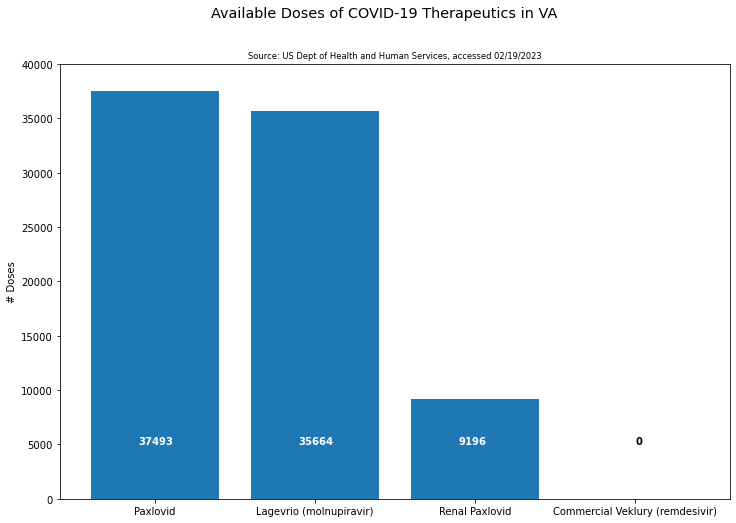

In [47]:
# Plot these results in a bar chart

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(meds, dose_count)

ax.set_ylabel("# Doses")
ax.set_ylim(0, 40000)

# Add annotations to show the total counts

ax.annotate(dose_count[0], (-0.1,5000), color="w", weight="bold")
ax.annotate(dose_count[1], (0.9,5000), color="w", weight="bold")
ax.annotate(dose_count[2], (1.9,5000), color="w", weight="bold")
ax.annotate(dose_count[3], (3,5000), weight="bold") # I will leave this text as black since there is no bar to set it against

# Add the data source and date in the subtitle
ax.set_title("Source: US Dept of Health and Human Services, accessed %s"%current_date, size="small") 

fig.suptitle("Available Doses of COVID-19 Therapeutics in VA", size="x-large")

plt.show()

The oral formulations of Paxlovid&#8482; and Lagevrio&#8482; are the most prevalent. Renal Paxlovid&#8482; would naturally be needed in fewer numbers, as it would usually be reserved for patients with kidney disease that contraindicates the regular formulation. At the time of this writing (February 2023), the pandemic has apparently subsided enough that the injection treatment remdesivir has been replaced by less-invasive oral treatments.

<a id="Geographic-Analysis"></a>
## Geographic Analysis

The HHS dataset contains geocoded data about therapeutic drug providers in the form of ZIP codes and latitude-longitude coordinates. In this section, we will visualize the prevalence of COVID-19 therapeutics across ZIP codes using a chloropleth (aka color scale) map.

A geographic json shapefile of Virginia ZIP codes is available from the Virginia Geographic Information Network (VGIN) via the __[ArcGIS website](http://hub.arcgis.com/datasets/VGIN::virginia-zip-codes/about)__. At the time of writing, I was unable to connect to the datafile via API, as I did with the HHS dataset. I will _hopefully_ resolve that technical difficulty soon, but in the meantime, the geojson file can be downloaded at this link: __[https://hub.arcgis.com/datasets/VGIN::virginia-zip-codes/about](https://hub.arcgis.com/datasets/VGIN::virginia-zip-codes/about)__.

In [82]:
# Read in the geojson file from VGIN

filepath = "Virginia_Zip_Codes.geojson" # Be sure to replace the portion in quotes with the correct filepath on your machine.
map_df = gpd.read_file(filepath)

In [83]:
# The data file contains a few North Carolina counties that border Virginia.
# We will subset the file to only contain Virginia counties. 

map_df = map_df[map_df.STATE=="VA"]
map_df.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,Shape__Area,Shape__Length,geometry
0,1,20105,ALDIE,VA,1.002221e+08,90779.784741,"MULTIPOLYGON (((-77.62273 39.02800, -77.62277 ..."
1,2,20106,AMISSVILLE,VA,1.443344e+08,84560.207942,"POLYGON ((-78.00685 38.76718, -78.00770 38.766..."
2,3,20109,MANASSAS,VA,5.758395e+07,53503.990994,"POLYGON ((-77.54081 38.84870, -77.54098 38.848..."
3,4,20110,MANASSAS,VA,3.680203e+07,40940.224989,"POLYGON ((-77.49564 38.77076, -77.49601 38.770..."
4,5,20111,MANASSAS,VA,4.318550e+07,54401.741830,"POLYGON ((-77.45200 38.73647, -77.45197 38.736..."


In [84]:
# In order to merge these two datasets, the HHS DataFrame (df) must be pivoted
# We want the pivot table to aggregate available drug courses by provider ZIP code

df_pivot = pd.pivot_table(data = df, values = "courses", index = "zip_code", aggfunc=np.sum)
df_pivot.reset_index(inplace=True)
df_pivot.head()

,zip_code,courses
0,20105,368
1,20109,407
2,20110,421
3,20111,42
4,20112,178


In [86]:
# Next, perform a left-join to match the map's ZIP codes to the pivot table's ZIP codes.

map_merge = map_df.merge(df_pivot, how="left", left_on="ZIP_CODE", right_on="zip_code")
map_merge = map_merge.assign(courses = map_merge.courses.fillna(0))
map_merge.head() # Note the map dataframe has 2 new columns on the right

,OBJECTID,ZIP_CODE,PO_NAME,STATE,Shape__Area,Shape__Length,geometry,zip_code,courses
0,1,20105,ALDIE,VA,1.002221e+08,90779.784741,"MULTIPOLYGON (((-77.62273 39.02800, -77.62277 ...",20105.0,368.0
1,2,20106,AMISSVILLE,VA,1.443344e+08,84560.207942,"POLYGON ((-78.00685 38.76718, -78.00770 38.766...",NaN,0.0
2,3,20109,MANASSAS,VA,5.758395e+07,53503.990994,"POLYGON ((-77.54081 38.84870, -77.54098 38.848...",20109.0,407.0
3,4,20110,MANASSAS,VA,3.680203e+07,40940.224989,"POLYGON ((-77.49564 38.77076, -77.49601 38.770...",20110.0,421.0
4,5,20111,MANASSAS,VA,4.318550e+07,54401.741830,"POLYGON ((-77.45200 38.73647, -77.45197 38.736...",20111.0,42.0


<AxesSubplot:title={'center':'Source: US Dept of Health and Human Services, accessed 02/19/2023'}>

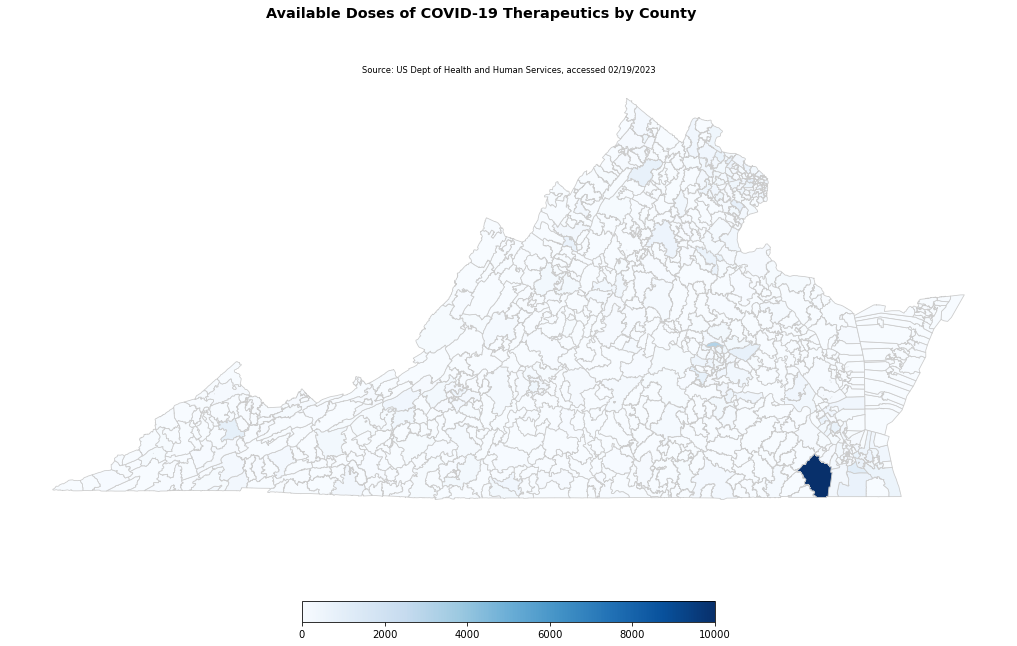

In [95]:
# Create the chloropleth map

fig, ax = plt.subplots(figsize=(30,10))
ax.axis("off")

fig.suptitle("Available Doses of COVID-19 Therapeutics by County", size="x-large", weight="bold")

sm = plt.cm.ScalarMappable(cmap="Blues", norm = plt.Normalize(vmin = 0, vmax = 10000))
sm.set_array([])

fig.colorbar(sm, orientation="horizontal", fraction=0.038)

ax.set_title("Source: US Dept of Health and Human Services, accessed %s"%current_date, size="small") 

map_merge.plot(column = "courses", cmap = "Blues", linewidth = 0.8, ax=ax, edgecolor="0.8")

### Unfortunately, this map is not a very helpful visual.

Suffolk, VA seems to be skewing the data to the point that the viewer cannot see a difference among the other counties. Let's investigate:

In [87]:
# Display the top 10 ZIP codes with the highest available number of courses.

df_pivot.sort_values(by="courses", ascending=False).head(10)

,zip_code,courses
177,23434,10479
123,23060,3242
165,23320,1165
267,24260,937
52,22192,871
37,22042,866
130,23112,838
129,23111,793
16,20164,792
96,22630,789


As the first map indicated, there are two unusually high outliers in the dataset: ZIP codes 23434 (Suffolk) and 23060 (Glen Allen). For the sake of simple exploration, I will _temporarily_ remove these two outliers to see how the map visualization changes.

In [88]:
# Limit the data to ZIP codes with 2,000 or fewer available doses.
map_trimmed = df_pivot[df_pivot.courses<=2000]

# Perform a left-join with the new subset
pivot_map_trimmed = map_df.merge(map_trimmed, how="left", left_on="ZIP_CODE", right_on="zip_code")
pivot_map_trimmed = pivot_map_trimmed.assign(courses = pivot_map_trimmed.courses.fillna(0))
pivot_map_trimmed.head()

,OBJECTID,ZIP_CODE,PO_NAME,STATE,Shape__Area,Shape__Length,geometry,zip_code,courses
0,1,20105,ALDIE,VA,1.002221e+08,90779.784741,"MULTIPOLYGON (((-77.62273 39.02800, -77.62277 ...",20105.0,368.0
1,2,20106,AMISSVILLE,VA,1.443344e+08,84560.207942,"POLYGON ((-78.00685 38.76718, -78.00770 38.766...",NaN,0.0
2,3,20109,MANASSAS,VA,5.758395e+07,53503.990994,"POLYGON ((-77.54081 38.84870, -77.54098 38.848...",20109.0,407.0
3,4,20110,MANASSAS,VA,3.680203e+07,40940.224989,"POLYGON ((-77.49564 38.77076, -77.49601 38.770...",20110.0,421.0
4,5,20111,MANASSAS,VA,4.318550e+07,54401.741830,"POLYGON ((-77.45200 38.73647, -77.45197 38.736...",20111.0,42.0


<AxesSubplot:title={'center':'Source: US Dept of Health and Human Services, accessed 02/19/2023'}>

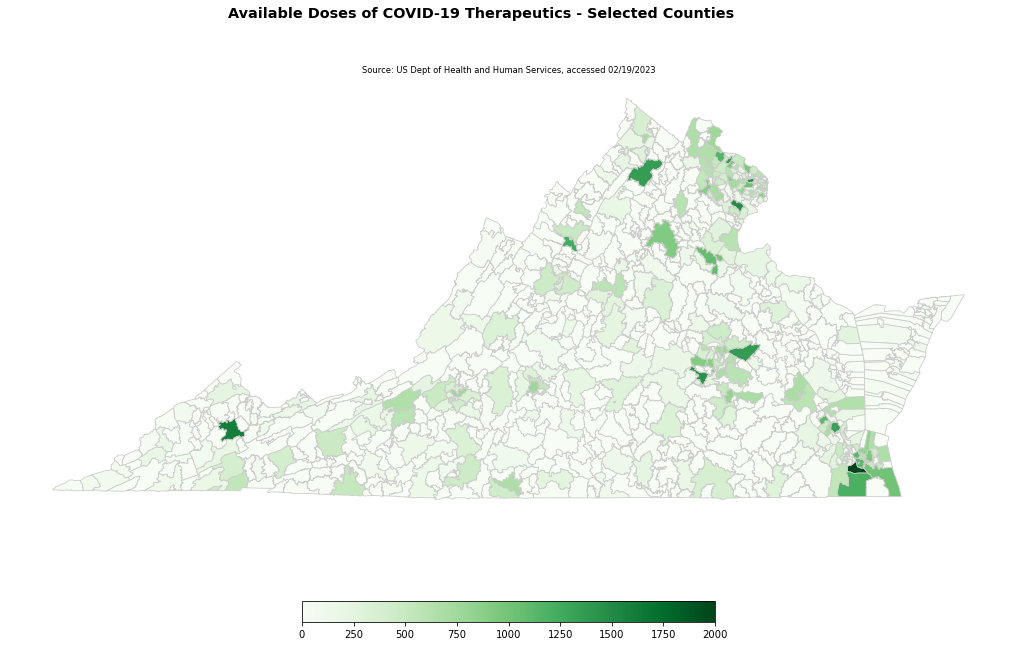

In [97]:
# Create a second chloropleth map, omitting the two outliers.

fig, ax = plt.subplots(figsize=(30,10))
ax.axis("off")

fig.suptitle("Available Doses of COVID-19 Therapeutics - Selected Counties", size="x-large", weight="bold")

sm = plt.cm.ScalarMappable(cmap="Greens", norm = plt.Normalize(vmin = 0, vmax = 2000)) # Rescale the legend to the new data

sm.set_array([])

fig.colorbar(sm, orientation="horizontal", fraction=0.038)

ax.set_title("Source: US Dept of Health and Human Services, accessed %s"%current_date, size="small") 

pivot_map_trimmed.plot(column = "courses", cmap = "Greens", linewidth = 0.8, ax=ax, edgecolor="0.8")

This map shows the differences among localities more clearly (except for the two ZIP codes that were filtered out). As one might expect, there appear to be larger amounts of therapeutics near more highly populated areas, namely Richmond, Virginia Beach, and the D.C. metro area.